In [4]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import intake

# Import Cdo-py
import cdo
cdo = cdo.Cdo(tempdir='/scratch/u/u233156/tmp/cdo-py') #change the tempdir to your scratch

import pickle

import os
    
plotdir = './plots/precip/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)  

import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')

#sns.set(font='Franklin Gothic Book',
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'black',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})



def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )


def convert_to_xarray_cycle2(ds,var,grid='1'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            lat=(["lat"], np.unique(ds.lat)),
            #lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
            # variable=var,
        ),
    )
    
    # attach griddes so that cdo interprets it as a regular lonlat grid:
    if grid=='1':
        my_griddes = '/work/bm1235/u233156/ifs-grids/multio_grids_cdoPython/1_griddes_latrevert'
    else:
        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
        
    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

In [7]:
# THIS STEP IS ONLY NECESSARY IF PICKLE IS NOT USED!!


cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'tco2559-ng5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 


array_yea= ["2020","2021","2022","2023","2024"]
array_mon= ["annual","JFMA","MJJA","SOND"]

array_exp      = ["IFS_4.4-FESOM_5-cycle3","ifs_cycle2_4km_tp","IFS_9-NEMO_25-cycle3","ifs_cycle2_9km_tp","IFS_9-FESOM_5-cycle3","ifs_cycle2_3km_tp"]
# FESOM family is red, NEMO family blue
array_color    = ["#ff0000","#ff0000","#0000ff","#0000ff","purple","darkorange"]
# give IFS resolution only, FESOM/NEMO don't change from 25/5km
array_labels   = ["Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-NEMO","Cycle 2, 9km, IFS-NEMO","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
# Cycle 3 is solid, Cycle 2/1 dashed
array_linestyle= ["solid","dashed","solid","dashed","solid","dashed"]
# main simulation is thicker to stand out
array_linewidth= [4,2,2,2,2,2]



mon_length = [12, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
data = cat.IFS['IFS_9-NEMO_25-cycle3']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords).groupby("lat").mean() # load medium-resolution here, monthly means (entire time series), zonal mean      
data["mon_length"] = (("time"), mon_length)
mon_len=data['mon_length']




dask_dict = {}
dask_dict_year = {}
for a,exp in enumerate(array_exp):
 if  array_linestyle[a] == "solid":  
    
    data = cat.IFS[f'{exp}']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].groupby("lat").mean()
    mon_len_exp = mon_len[0:len(data)]   
    data = data * mon_len_exp 
    
    month_idxs=data.groupby_bins("time.month", [0, 4, 8, 12]).sum() # put in groups JFMA MJJA SOND
    month_len_idxs=mon_len_exp.groupby_bins("time.month", [0, 4, 8, 12]).sum()
    month_weighted_idxs = month_idxs / month_len_idxs
    
    dask_dict[a,0]=data.sum(dim="time")/mon_len_exp.sum()
    for m in range(1,4):
      dask_dict[a,m]=month_weighted_idxs[m-1]    
    
    year_idxs=data.groupby('time.year').groups  
    
    for y,year in enumerate(array_yea):
     if len(year_idxs) > y:
      idxs_year=year_idxs[int(year)] 
      data_year=data.isel(time=idxs_year)    
      mon_len_year=mon_len_exp.isel(time=idxs_year)   
    
      month_idxs=data_year.groupby_bins("time.month", [0, 4, 8, 12]).sum() # put in groups JFMA MJJA SOND
      month_len_idxs=mon_len_year.groupby_bins("time.month", [0, 4, 8, 12]).sum() # put in groups JFMA MJJA SOND
      month_weighted_idxs = month_idxs / month_len_idxs
        
      dask_dict_year[a,y,0]=data_year.sum(dim="time")/mon_len_year.sum()
      for m in range(1,4):
        dask_dict_year[a,y,m]=month_weighted_idxs[m-1]
     else:
      dask_dict_year[a,y,0]=0
      dask_dict_year[a,y,1]=0
      dask_dict_year[a,y,2]=0
      dask_dict_year[a,y,3]=0
      dask_dict_year[a,y,4]=0
 else:
    ds_cycle2_9km_tp=xr.open_dataset("/work/bm1235/a270046/cycle2-sync/monthly_means/9km/tp_9km.nc")
    ds_cycle2_4km_tp=xr.open_dataset("/work/bm1235/a270046/cycle2-sync/monthly_means/4km/tp_4km.nc")
    ds_cycle2_3km_tp=xr.open_dataset("/work/bm1235/a270046/cycle2-sync/monthly_means/2.8km/tp_2.8km.nc")

    ifs_cycle2_9km_tp = convert_to_xarray_cycle2(ds_cycle2_9km_tp,var='tp',grid='1')
    ifs_cycle2_4km_tp = convert_to_xarray_cycle2(ds_cycle2_4km_tp,var='tp',grid='1')
    ifs_cycle2_3km_tp = convert_to_xarray_cycle2(ds_cycle2_3km_tp,var='tp',grid='1')

    data2 = globals()[f'{exp}'].groupby("lat").mean(dim="lon") # load medium-resolution here, monthly means (entire time series), zonal mean      
    data2["mon_length"] = (("time"), mon_length[0:len(data2)])
    mon_len_exp2=data2['mon_length']
    data2 = data2*mon_len_exp2

    month_idxs=data2.groupby_bins("time.month", [0, 4, 8, 12]).sum(dim="time") # put in groups JFMA MJJA SOND
    month_len_idxs=mon_len_exp2.groupby_bins("time.month", [0, 4, 8, 12]).sum()
    month_weighted_idxs = month_idxs / month_len_idxs
    
    if len(data2.groupby('time.month').groups) == 12:
      dask_dict[a,0]=data2.sum(dim="time")/mon_len_exp2.sum()
    else:
      dask_dict[a,0]=0
    
    for m in range(1,4):
      if month_idxs[m-1].notnull().all():
        dask_dict[a,m]=month_weighted_idxs[m-1]    
      else:
        dask_dict[a,m]=0

    year_idxs=data2.groupby('time.year').groups  

    for y,year in enumerate(array_yea):
     if len(year_idxs) > y and len(year_idxs) > 1:
      idxs_year=year_idxs[int(year)] 
      data2_year=data2.isel(time=idxs_year)    
      mon_len_year=mon_len_exp2.isel(time=idxs_year)   
    
      month_idxs=data2_year.groupby_bins("time.month", [0, 4, 8, 12]).sum() # put in groups JFMA MJJA SOND
      month_len_idxs=mon_len_year.groupby_bins("time.month", [0, 4, 8, 12]).sum() # put in groups JFMA MJJA SOND
      month_weighted_idxs = month_idxs / month_len_idxs
      
      if len(data2_year.groupby('time.month').groups) == 12:
        dask_dict_year[a,y,0]=data2_year.sum(dim="time")/mon_len_year.sum()
      else:
        dask_dict_year[a,y,0]=0
      
      for m in range(1,4):
        dask_dict_year[a,y,m]=month_weighted_idxs[m-1]
     else:
      dask_dict_year[a,y,0]=0
      dask_dict_year[a,y,1]=0
      dask_dict_year[a,y,2]=0
      dask_dict_year[a,y,3]=0
      dask_dict_year[a,y,4]=0    
    
    
indir_GPM   = "/work/bm1235/observations/GPM_IMERG/"

PrGclim = {}

file=f'{indir_GPM}/GPM_IMERG_hourly_2010to2020_annualmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrGclim[0] = np.squeeze(Pr)

file=f'{indir_GPM}/GPM_IMERG_hourly_2010to2020_month_JFMA_timmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrGclim[1] = np.squeeze(Pr)


file=f'{indir_GPM}/GPM_IMERG_hourly_2010to2020_month_MJJA_timmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrGclim[2] = np.squeeze(Pr)


file=f'{indir_GPM}/GPM_IMERG_hourly_2010to2020_month_SOND_timmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrGclim[3] = np.squeeze(Pr)




indir_GPM   = "/work/bm1235/observations/GPM_IMERG/"

PrG = {}

file=f'{indir_GPM}/GPM_IMERG_hourly_2020_annualmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrG[0] = np.squeeze(Pr)

file=f'{indir_GPM}/GPM_IMERG_hourly_2020_JFMA_timmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrG[1] = np.squeeze(Pr)


file=f'{indir_GPM}/GPM_IMERG_hourly_2020_MJJA_timmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrG[2] = np.squeeze(Pr)


file=f'{indir_GPM}/GPM_IMERG_hourly_2020_SOND_timmean.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
Pr = np.mean(Pr[:,:],2)  *24 # average over all lons
PrG[3] = np.squeeze(Pr)



indir_GPM   = "/work/bm1235/observations/GPM_IMERG/"

PrGmin = {}

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_alltimes_zonmean_timmin.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmin[0] = np.squeeze(Pr) *24

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_JFMA_zonmean_timmin.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmin[1] = np.squeeze(Pr) *24

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_MJJA_zonmean_timmin.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmin[2] = np.squeeze(Pr) *24

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_SOND_zonmean_timmin.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmin[3] = np.squeeze(Pr) *24


PrGmax = {}

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_alltimes_zonmean_timmax.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmax[0] = np.squeeze(Pr) *24

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_JFMA_zonmean_timmax.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmax[1] = np.squeeze(Pr) *24

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_MJJA_zonmean_timmax.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmax[2] = np.squeeze(Pr) *24

file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_SOND_zonmean_timmax.nc'
Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
PrGmax[3] = np.squeeze(Pr) *24



# WRITE PICKLE

# Open a file and use dump()
with open('../data/precip_annual_seasonal.pickle', 'wb') as file:
      
    # A new file will be created
    pickle.dump([dask_dict,dask_dict_year,PrG,PrGmin,PrGmax,PrGclim], file)  

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [5]:
# CONTINUE HERE IF PICKLE IS USED

with open(f'../data/precip_annual_seasonal.pickle', 'rb') as file:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    dask_dict,dask_dict_year,PrG,PrGmin,PrGmax,PrGclim = pickle.load(file)

annual
Cycle 3, 4.4km, IFS-FESOM
Cycle 2, 4.4km, IFS-FESOM
Cycle 3, 9km, IFS-NEMO
Cycle 2, 9km, IFS-NEMO
Cycle 3, 9km, IFS-FESOM
JFMA
Cycle 3, 4.4km, IFS-FESOM
Cycle 2, 4.4km, IFS-FESOM
Cycle 3, 9km, IFS-NEMO
Cycle 2, 9km, IFS-NEMO
Cycle 3, 9km, IFS-FESOM
Cycle 2, 2.8km, IFS-FESOM
MJJA
Cycle 3, 4.4km, IFS-FESOM
Cycle 2, 4.4km, IFS-FESOM
Cycle 3, 9km, IFS-NEMO
Cycle 2, 9km, IFS-NEMO
Cycle 3, 9km, IFS-FESOM
Cycle 2, 2.8km, IFS-FESOM
SOND
Cycle 3, 4.4km, IFS-FESOM
Cycle 2, 4.4km, IFS-FESOM
Cycle 3, 9km, IFS-NEMO
Cycle 2, 9km, IFS-NEMO
Cycle 3, 9km, IFS-FESOM


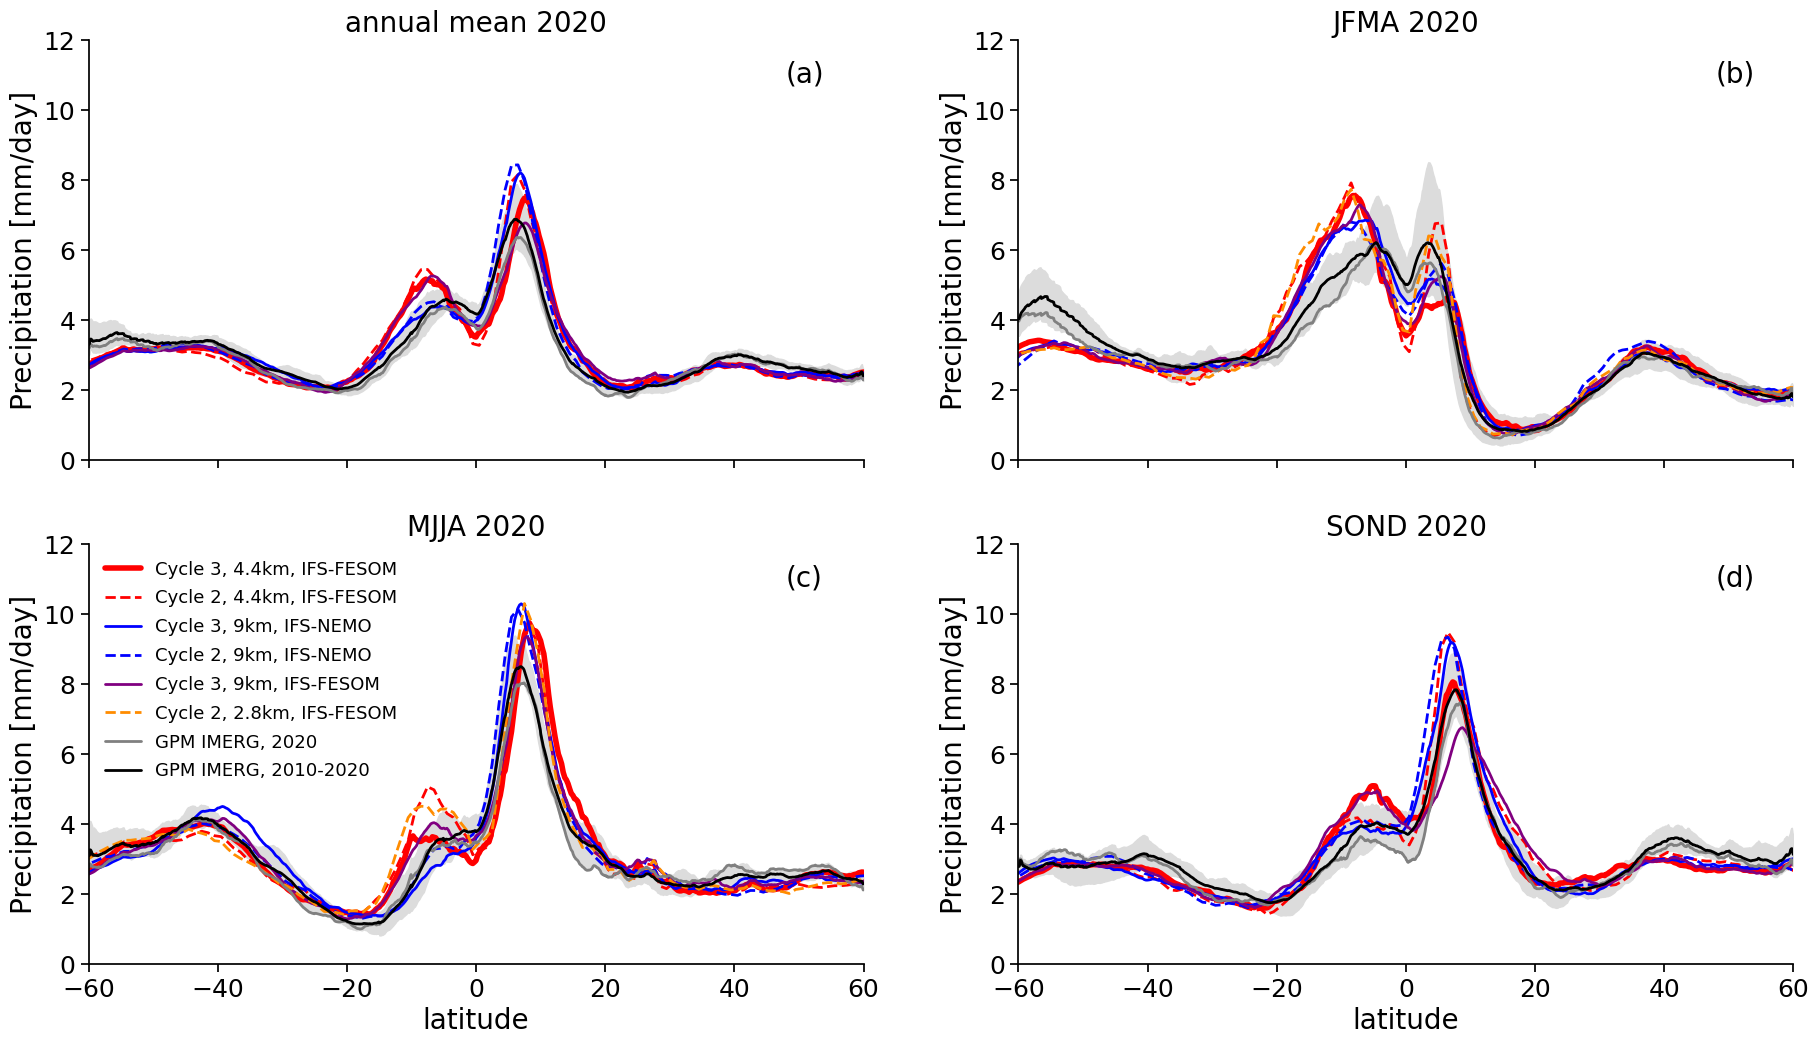

In [6]:
array_yea= ["2020","2021","2022","2023","2024"]
array_mon= ["annual","JFMA","MJJA","SOND"]

array_exp      = ["IFS_4.4-FESOM_5-cycle3","ifs_cycle2_4km_tp","IFS_9-NEMO_25-cycle3","ifs_cycle2_9km_tp","IFS_9-FESOM_5-cycle3","ifs_cycle2_3km_tp"]
# FESOM family is red, NEMO family blue
array_color    = ["#ff0000","#ff0000","#0000ff","#0000ff","purple","darkorange"]
# give IFS resolution only, FESOM/NEMO don't change from 25/5km
array_labels   = ["Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-NEMO","Cycle 2, 9km, IFS-NEMO","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
# Cycle 3 is solid, Cycle 2/1 dashed
array_linestyle= ["solid","dashed","solid","dashed","solid","dashed"]
# main simulation is thicker to stand out
array_linewidth= [4,2,2,2,2,2]



# calendar plot for all years in one
fig, axs = plt.subplots(2,2, figsize=(22, 12), sharex=True, sharey=False)

                   

# set labels
plt.setp(axs[-1], xlabel='latitude') # only plot this for the last element
plt.setp(axs[:], ylabel='Precipitation [mm/day]')
plt.setp(axs[:], xlim=(-60, 60))
plt.setp(axs[:], ylim=(0, 12))
plt.yticks()     

Title= ["annual mean 2020","JFMA 2020","MJJA 2020","SOND 2020"]
subplot_label= ["(a)","(b)","(c)","(d)"]

for mon,(i,ax) in zip(array_mon,enumerate(axs.flat)):  
     print(mon)
     ax.set_title(Title[i])

     ax.fill_between(PrGmin[i].lat, PrGmin[i], PrGmax[i],
          color="gainsboro",)      
    
 
     for (a,exp),color,labels,linestyle,linewidth in zip(enumerate(array_exp),array_color,array_labels,array_linestyle,array_linewidth):          
      if exp == "ifs_cycle2_4km_tp" or exp == "ifs_cycle2_3km_tp": 
         if not isinstance(dask_dict[a,i], int):
           filP_y = np.squeeze(dask_dict[a,i]) *1000 *86400    
           print(labels)
           ax.plot(filP_y.lat,
                   filP_y,
                   color=color,
                   linestyle=linestyle,
                   label=labels,
                   linewidth=linewidth) 
      else:
       if not isinstance(dask_dict_year[a,0,i], int):
           filP_y = np.squeeze(dask_dict_year[a,0,i]) *1000 *86400 
           print(labels)
           ax.plot(filP_y.lat,
                   filP_y,
                   color=color,
                   linestyle=linestyle,
                   label=labels,
                   linewidth=linewidth)    

     filPrG=PrG[i]
     ax.plot(filPrG.lat,
          filPrG,
          color="grey",
          linestyle='solid',
          label="GPM IMERG, 2020",
          linewidth=2)    
    
     filPrGclim=PrGclim[i]
     ax.plot(filPrGclim.lat,
          filPrGclim,
          color="black",
          linestyle='solid',
          label="GPM IMERG, 2010-2020",
          linewidth=2)    
    
     if i==2:
      # Add legend
      handles, labels = ax.get_legend_handles_labels()
      ax.legend(handles,
          labels,
          loc='upper left',
          frameon=False,
          fontsize=13,
          labelspacing=.6)

     ax.tick_params(axis='y', labelsize=18)              
     ax.tick_params(axis='x', labelsize=18)        
     
     ax.annotate(subplot_label[i], xy=(0.9, 0.9), xycoords="axes fraction")

fig.savefig(plotdir + f'precip_zonmean_NextGEMS_Cycle2_vs_3_GPM_filled_annualmean_seasonal_2020.png')  
fig.savefig(plotdir + f'precip_zonmean_NextGEMS_Cycle2_vs_3_GPM_filled_annualmean_seasonal_2020.pdf')  